In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import WeekdayLocator, DateFormatter
from scipy.optimize import curve_fit

In [2]:
today = pd.Timestamp.today()
'Вычисления выполнены {}'.format(today)

'Вычисления выполнены 2020-04-01 12:37:21.404917'

# Исходные данные

Мы воспользуемся открытыми глобальными данными [Университета Джонса Хопкинса](https://coronavirus.jhu.edu/).

Исходные данные получим из репозитория  Johns Hopkins CSSE: [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)

Мы загружаем данные о заражённых, умерших и выздоровевших по странам. Они обновляются каждые сутки, поэтому можно будет следить за динамикой, просто запуская этот Jupyter Notebook раз в день.

In [3]:
confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
recovered_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

confirmed_data = pd.read_csv(confirmed_url)
deaths_data = pd.read_csv(deaths_url)
recovered_data = pd.read_csv(recovered_url)

confirmed_data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,40,40,74,84,94,110,110,120,170,174
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,89,104,123,146,174,186,197,212,223,243
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,201,230,264,302,367,409,454,511,584,716
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,113,133,164,188,224,267,308,334,370,376
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,3,3,3,4,4,5,7,7,7


Напишем функцию для преобразования данных к удобному для анализа виду. 

1. Избавимся от ненужных столбцов: `drop(['Province/State', 'Lat', 'Long'], axis=1)`.
2. Найдём сумму всех случаев заражений по каждой стране, то есть исключим деление на штаты/районы/провинции: `groupby(by='Country/Region').sum()`.
3. Транспонируем таблицу `transpose()`, чтобы даты стали столбцом `'date'`, а названия стран стали столбцами.
4. Столбец с датами делаем индексом, таким образом получаем полноценный временной ряд.

Поскольку эту операцию нужно проделать со всеми таблицами, то напишем сначала функцию, а затем применим её к исходным данным.

In [4]:
def transform_data(data):
    data = (data
             .drop(['Province/State', 'Lat', 'Long'], axis=1)
             .groupby(by='Country/Region').sum()
             .transpose()
             .rename({'Country/Region' : 'date'})
            )

    data.index = pd.to_datetime(data.index)
    data.index.name = 'Дата'
    return data

confirmed = transform_data(confirmed_data.copy())
deaths = transform_data(deaths_data.copy())
recovered = transform_data(recovered_data.copy())

confirmed.tail()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe
Дата,,,,,,,,,,,,,,,,,,,,,
2020-03-27,110,186,409,267,4,7,589,329,3143,7657,...,310,405,14745,238,88,107,163,91,22,5
2020-03-28,110,197,454,308,5,7,690,407,3640,8271,...,356,468,17312,274,104,119,174,98,28,7
2020-03-29,120,212,511,334,7,7,745,424,3984,8788,...,475,570,19780,304,144,119,188,109,29,7
2020-03-30,170,223,584,370,7,7,820,482,4361,9618,...,548,611,22453,310,149,135,203,116,35,7
2020-03-31,174,243,716,376,7,7,1054,532,4559,10180,...,645,664,25481,338,172,135,212,119,35,8


In [5]:
cases_global = pd.DataFrame({
    'Заболевшие': confirmed.sum(axis='columns'),
    'Умершие': deaths.sum(axis='columns'),
    'Выздоровевшие': recovered.sum(axis='columns')})

# Изучаем данные

## Глобальные показатели

Важной описательной статистикой для эпидемий является летальность и смертность. 

* **Летальность** заболевания это отношение смертей к общему числу заболевших. 
* **Смертность** заболевания это отношение умерших к средней численности популяции.

Окончательные показатели летальности и смертности можно будет вычислить только после того как пандемия закончится и будут опубликованы официальные окончательные цифры. Однако ничто не мешает следить за текущей статистикой.

Вычисляем летальность (англ. case fatality rate):

In [6]:
cfr = (cases_global['Умершие'] / cases_global['Заболевшие'])
'Летальность: {:.2f}%'.format(np.around(float(cfr.tail(1)) * 100, 2))

'Летальность: 4.91%'

Эти цифры можно сравнить с другими заболеваниями: [List of human disease case fatality rates](https://en.wikipedia.org/wiki/List_of_human_disease_case_fatality_rates)

На данный момент коронавирус более летален, чем любой из известных гриппов (у сезонного < 0.1%) и, например, малярия (~0.3%). Однако можно ожидать, что летальность в итоге уменьшится, особенно когда будут проведены оценки невыявленных случаев. 

Тем не менее, **сейчас цифры очень серьезные**.

Смертность обычно оценивают в промилле ‰, то есть в тысячной доле (процент это сотая доля). Мы возьмём приблизительную численность населения планеты в 7,7 млрд. человек.

In [7]:
world_population = 7.7e9
mortality_rate = cases_global['Умершие'] / world_population
'Смертность: {:.5f}‰'.format(float(mortality_rate.tail(1)) * 1000)

'Смертность: 0.00547‰'

А сколько всего человек заболело от общей численности населения?

In [8]:
confirmed_perc = cases_global['Заболевшие'] / world_population
('Заразились {} чел., это {:.5f}% от ' 
 'населения планеты.'.format(int(cases_global['Заболевшие'].tail(1)),
                                                    float(confirmed_perc.tail(1)) * 100))

'Заразились 857487 чел., это 0.01114% от населения планеты.'

По сравнению с летальностью, смертность реже используется для характеристики эпидемии и пандемии. Оно и понятно, когда станет ясно, что смертность высокая, будет уже поздно принимать меры. Это же касатеся и прочих оценок, полученных как  отношение к общей численности населения.

Теперь пора построить графики. Сначала напишем общую для всех них функцию.

In [9]:
def plot_cases(df, **kwargs):
    ax = df.plot(figsize=(8, 4), grid=True)
    ax.set(**kwargs)
    
    ax.set_ylabel('Число человек')
    ax.xaxis.set_minor_formatter(plt.NullFormatter())
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    ax.xaxis.set_major_formatter(DateFormatter('%b %d'))
    return ax

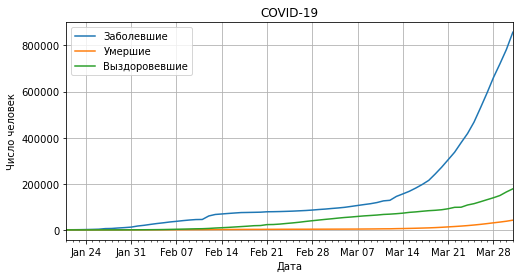

In [10]:
%matplotlib inline
plot_cases(cases_global, title='COVID-19')

Text(0, 0.5, 'Летальность, %')

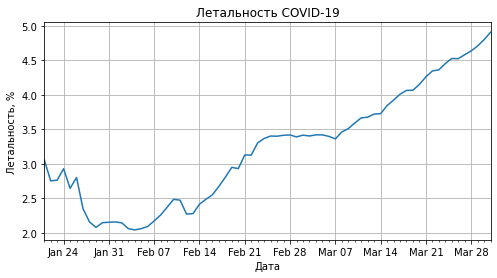

In [11]:
ax = plot_cases(cfr*100, title='Летальность COVID-19')
ax.set_ylabel('Летальность, %')

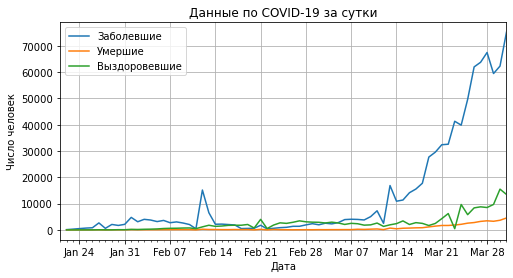

In [12]:
plot_cases(cases_global.diff(), title='Данные по COVID-19 за сутки')

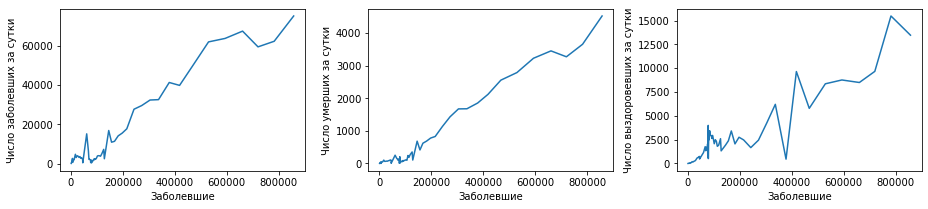

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 3))
ax1.plot(cases_global['Заболевшие'], cases_global['Заболевшие'].diff())
ax2.plot(cases_global['Заболевшие'], cases_global['Умершие'].diff())
ax3.plot(cases_global['Заболевшие'], cases_global['Выздоровевшие'].diff())

for ax in fig.get_axes():
    ax.set_xlabel('Заболевшие')

ax1.set_ylabel('Число заболевших за сутки')
ax2.set_ylabel('Число умерших за сутки')
ax3.set_ylabel('Число выздоровевших за сутки')

fig.tight_layout()

## Данные по лидирующим странам

In [14]:
def get_top_countries_names(top):
    ranked = confirmed.tail(1).rank(axis='columns', ascending=False)
    top_countries = ranked.columns[(ranked <= top).values[0]]
    top_countries = top_countries[np.argsort(ranked[top_countries].values)[0]]
    return top_countries

In [15]:
top = 10
top_countries = get_top_countries_names(top)
confirmed[top_countries].tail()

Country/Region,US,Italy,Spain,China,Germany,France,Iran,United Kingdom,Switzerland,Turkey
Дата,,,,,,,,,,
2020-03-27,101657,86498,65719,81897,50871,33402,32332,14745,12928,5698
2020-03-28,121478,92472,73235,81999,57695,38105,35408,17312,14076,7402
2020-03-29,140886,97689,80110,82122,62095,40708,38309,19780,14829,9217
2020-03-30,161807,101739,87956,82198,66885,45170,41495,22453,15922,10827
2020-03-31,188172,105792,95923,82279,71808,52827,44605,25481,16605,13531


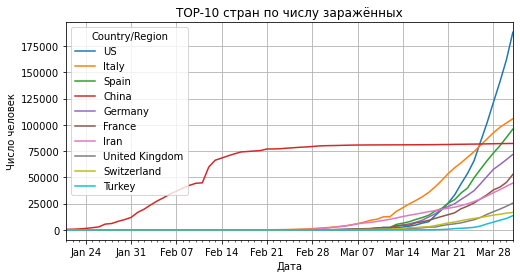

In [16]:
plot_cases(confirmed[top_countries], title='TOP-{} стран по числу заражённых'.format(top))

Графики распространения эпидемии во всех странах очень похожи, значит можно попробовать подобрать однотипную модель, описывающую процесс. Посмотрим на то, какая ситуация с числом заражений в день.

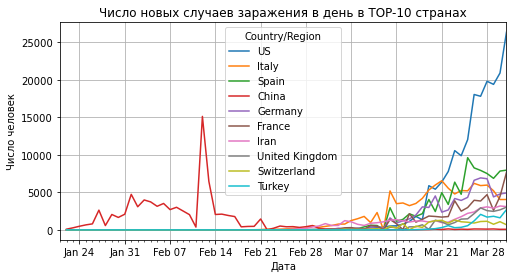

In [17]:
plot_cases(confirmed[top_countries].diff(),
           title='Число новых случаев заражения в день в TOP-{} странах'.format(top))

Видно, что скорость заражения в некоторых лидирующих странах превзошла аналогичные показатели у Китая. Таким образом, китайская модель довольно благоприятна и оптимистична, но стала она такой благодаря жёстким карантинным мерам.

Теперь посмотрим на летальность по лидирующим странам. 

In [18]:
((deaths[top_countries] / confirmed[top_countries]).tail(1) * 100).round(1)

Country/Region,US,Italy,Spain,China,Germany,France,Iran,United Kingdom,Switzerland,Turkey
Дата,,,,,,,,,,
2020-03-31,2.1,11.7,8.8,4.0,1.1,6.7,6.5,7.0,2.6,1.6


Виден очень сильный разброс и довольно большое отличие от среднего по всему миру. 

Посмотрите на Италию, это невероятно огромные цифры по летальности.


# Модель роста числа заболевших

Как на самом деле моделируют эпидемии можно посмотреть в [Википедии](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). 

Модифицированные модели под COVID-19 можно пощупать [здесь](https://neherlab.org/covid19/?%7B%22population%22%3A%7B%22populationServed%22%3A144000000%2C%22country%22%3A%22Russian%20Federation%22%2C%22hospitalBeds%22%3A1172000%2C%22ICUBeds%22%3A40000%2C%22suspectedCasesToday%22%3A2%2C%22importsPerDay%22%3A5%2C%22cases%22%3A%22Russian%20Federation%22%7D%2C%22epidemiological%22%3A%7B%22r0%22%3A2.7%2C%22incubationTime%22%3A5%2C%22infectiousPeriod%22%3A3%2C%22lengthHospitalStay%22%3A7%2C%22lengthICUStay%22%3A14%2C%22seasonalForcing%22%3A0.2%2C%22peakMonth%22%3A0%2C%22overflowSeverity%22%3A2%7D%2C%22simulation%22%3A%7B%22simulationTimeRange%22%3A%7B%22tMin%22%3A%222020-03-01T08%3A00%3A00.000Z%22%2C%22tMax%22%3A%222020-12-31T08%3A00%3A00.000Z%22%7D%2C%22numberStochasticRuns%22%3A0%7D%2C%22containment%22%3A%5B%7B%22t%22%3A%222020-03-01T08%3A00%3A00.000Z%22%2C%22y%22%3A0.997554347826087%7D%2C%7B%22t%22%3A%222020-04-04T05%3A20%3A00.000Z%22%2C%22y%22%3A0.8317934782608696%7D%2C%7B%22t%22%3A%222020-05-08T02%3A40%3A00.000Z%22%2C%22y%22%3A0.8%7D%2C%7B%22t%22%3A%222020-06-11T00%3A00%3A00.000Z%22%2C%22y%22%3A0.8%7D%2C%7B%22t%22%3A%222020-07-14T21%3A20%3A00.000Z%22%2C%22y%22%3A0.8%7D%2C%7B%22t%22%3A%222020-08-17T18%3A40%3A00.000Z%22%2C%22y%22%3A0.8%7D%2C%7B%22t%22%3A%222020-09-20T16%3A00%3A00.000Z%22%2C%22y%22%3A0.8%7D%2C%7B%22t%22%3A%222020-10-24T13%3A20%3A00.000Z%22%2C%22y%22%3A0.8%7D%2C%7B%22t%22%3A%222020-11-27T10%3A40%3A00.000Z%22%2C%22y%22%3A0.8%7D%2C%7B%22t%22%3A%222020-12-31T08%3A00%3A00.000Z%22%2C%22y%22%3A0.8%7D%5D%2C%22current%22%3A%7B%22overall%22%3A%22Custom%22%2C%22population%22%3A%22Custom%22%2C%22epidemiological%22%3A%22Custom%22%2C%22containment%22%3A%22Weak%20mitigation%22%7D%7D) и [здесь](http://covidsim.eu/). 

Эти модели хорошо работают, в том числе и для России (с жёстким карантином прогноз очень благоприятный ~10 тыс. заболевших, без него - около миллиона заболевших к середине июня ([источник](https://www.proekt.media/research/koronavirus-regiony/))), но там можно утонуть в параметрах, мы же хотим что-нибудь попроще, но что более или менее будет работать, конечно. По ссылкам загляуть всё же стоит, дабы оценить насколько примитивным будет наш дальнейший подход.

Посмотрим внимательно на Китай и Южную Корею.

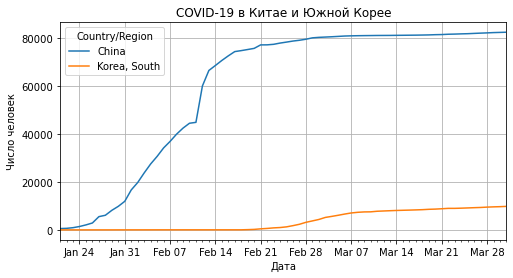

In [19]:
ax = plot_cases(confirmed[['China', 'Korea, South']],
                title='COVID-19 в Китае и Южной Корее'.format(top))

В этих странах распространение замедлилось и довольно давно. Обращают на себя две особенности.

* Во-первых, график является не экспонентой, а похож на [логистическу S-кривую](https://ru.wikipedia.org/wiki/%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D1%83%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5), то есть с медленным ростом в начале и в конце, но с быстрым в середине.

* Во-вторых, в отличие от логистической кривой, наши графики не являются симметричными: правая часть более пологая и протяжённая.

Мы для простоты опустим вторую особенность и перейдём к описанию возможной модели.


# Логистическое уравнение и функция

Нас интересует обыкновенное дифференциальное уравнение вида
$$\dfrac{d}{dt} y(t) = cy (t) \left( 1 - \dfrac{y(t)}{a} \right),$$
которое называется [логистическим или уравнением Ферхюльста](https://en.wikipedia.org/wiki/Logistic_function).

* Уравнение связывает скорость $\frac{d}{dt}y(t)$ заражения с максимально возможным числом заражённых $a$. Параметр $c$ пропорционален скорости.

* Поскольку в правой части уравнения находится и число заражённых $y$ и и максимально возможное число заражённых $a$, то и скорость заражения зависит от них.

* Когда все будут заражены, то есть $y = a$, выражение в скобках, а значит и вся правая часть, обратится в нуль и рост прекратится.

* Когда число зараженных очень мало, то есть $y << a$, выражение в скобках $\approx 1$,  в этом случае
$$\dfrac{d}{dt} y(t) = cy(t) \left( 1 - \dfrac{y(t)}{a} \right) \approx cy(t),$$
что является дифференциальным уравнением для экспоненциального роста. То есть действительно в начале эпидемии рост похож на экспоненциальный.

Решением логистического уравнения служит **логистическая функция**
$$ \boxed{y (t) = \dfrac{a}{1 + b\exp\left(-c t\right)}}$$
где 
* $y (t)$ является общим числом заражённых в момент времени $t$,

* $\exp(x)$ это экспоненциальная функция $e^x$,

* $b$ это параметр, связанный с исходным числом заражённых а момент $t=0$
$$y_0 (t = 0) = \dfrac{a}{1 + b},$$

* $c > 0$ является параметром роста,

* $e$ это число Эйлера.

Параметр роста $c$ можно попробовать соотнести (не знаю, обоснованно ли) с базовым репродуктивным числом $R_0 = 1 / c$, то есть со средним количеством лиц, напрямую инфицированных больным в течение всего заразного периода при условии попадания его в полностью уязвимую популяцию. Уязвимую здесь означает без иммунитета, как раз наша ситуация. Коротко $R_0$ можно назвать заразностью.

Легко также найти производную логистической функции
$$\dfrac{d}{dt}y (t) = \dfrac{abc \exp{(-ct)}}{(1 + b\exp{(-ct)})^2}$$.

Логистическая функция является симметричной, поэтому максимальная скорость заражения будет тогда, когда будет заражена половина от всех тех, кто может заразиться, то есть 
$$ y(t) = \dfrac{c}{2},\quad t = \dfrac{\ln{b}}{c}.$$



In [20]:
def logistic(t, a, b, c):
    """Logistic growth.
    """
    return a / (1 + b * np.exp(-c * t))

def logistic_deriv(t, a, b, c):
    """Logistic growth derivation.
    """
    return a * b * c * np.exp(-c * t) / (1 + b * np.exp(-c * t))**2

def maximum_rate(b, c):
    return np.log(b) / c

# Определение параметров модели


Посмотрим теперь, как наша модель работает на реальных данных. 

Нам необходимо определить параметры модели, то есть коэффициенты $a, b ,c$. Сначала приводим необходимые функции.

In [21]:
def fit_model(
    data_model,
    bounds=(0, [10e6, 10e6, 1.0]),
    p0=[50000, 30, 0.2]):
    
    data_model = data_model.dropna()
    
    delta_t0 = (data_model.index.to_julian_date() -
                data_model.index[0].to_julian_date())

    params, cov = curve_fit(
        logistic, delta_t0,
        data_model.values,
        bounds=bounds, p0=p0,
        max_nfev=1e5
    )

    params_stdev = np.sqrt(np.diag(cov))
    
    mrt_days = int(maximum_rate(*params[1:]))
    mrt_date = pd.to_timedelta(
        mrt_days, unit='days') + data_model.index[0]
    mrt = int(logistic_deriv(mrt_days, *params))
    
    out = {'a': int(params[0]), 'a_std': int(params_stdev[0]),
          'b': params[1], 'b_std': params_stdev[1],
          'c': params[2], 'c_std': params_stdev[2],
           'mrt' : mrt, 'mrt_date':mrt_date, 'mrt_days': mrt_days,
           'start_date': data_model.index[0], 'R0' : np.around(1/params[2], 1)
          }
    return pd.Series(out)

def print_report(res):
    print('Начало: {:%Y-%m-%d}'.format(res.start_date))
    print("Максимальное число заражённых:" 
          "a = {:.0f} +\- {:.0f}".format(res.a, res.a_std))
    print('b = {:.2f} +\- {:.2f}'.format(res.b, res.b_std))
    print('c = {:.4f} +\- {:.4f}'.format(res.c, res.c_std))
    print('Заразность R0 = {:.1f}'.format(res.R0))
    print("Макс. скорость заражения {:.0f} чел./сутки " 
          "наступит {:%Y-%m-%d}, через {:.0f} дн. после начала.".format(
              res.mrt, res.mrt_date, res.mrt_days))
    
def plot_prediction(data_model, res, days=90):
    dates_extra = pd.to_timedelta(days, unit='days')
    date_predict = (pd.date_range(data_model.index[0],
                                  data_model.index[0] +
                                  dates_extra))
    date_predict_delta = (date_predict.to_julian_date() -
                          data_model.index[0].to_julian_date())
    predicted = pd.Series(
        logistic(date_predict_delta, res.a, res.b, res.c),
        index=date_predict, name='Логистическая модель')

    data_plot = pd.DataFrame({
        'Логистическая модель': predicted,
        'Реальные данные': data_model})
    
    ax = plot_cases(data_plot)
    ax.axvline(x=res.mrt_date, color='g',
               label='Макс. скорость')
    ax.legend()
    return ax

Теперь построим модель для Китая по полным доступным данным.

Начало: 2020-01-22
Максимальное число заражённых:a = 81213 +\- 336
b = 50.59 +\- 5.33
c = 0.2204 +\- 0.0059
Заразность R0 = 4.5
Макс. скорость заражения 4439 чел./сутки наступит 2020-02-08, через 17 дн. после начала.


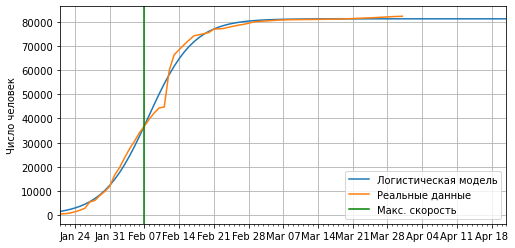

In [22]:
country = 'China'
data_model = confirmed[country].copy()

data_model[data_model == 0] = np.nan
data_model = data_model.dropna()

res = fit_model(data_model)
print_report(res)
plot_prediction(data_model, res)

Выглядит неплохо. Однако сила моделирования в способности предсказывать. Если бы сейчас было начало февраля, смогли бы мы предсказать общее число заражённых в Китае на сегодняшний день? С какого момента модель начинает давать близкие к реальности результаты?

Для ответа на эти вопросы проанализируем сходимость педсказанных моделью значений к реальными данным за последние сутки.

In [23]:
def plot_convergence(data_model, freq='1D', print_iterations=False):
    min_d = pd.to_timedelta(10, unit='D')
    date_range = pd.date_range(data_model.index[0] +
                               min_d, data_model.index[-1],
                               freq=freq)[1:]

    results = []
    for date in date_range:
        data_i = data_model.loc[data_model.index[0]:date]
        res_i = fit_model(data_i)
        res_i['Дата'] = date
        predict_date = (confirmed.index[-1].to_julian_date() -
                        res_i.start_date.to_julian_date())
        res_i['predicted'] = logistic(
            predict_date, res_i.a, res_i.b, res_i.c)
        results.append(res_i)
        if print_iterations:
            print('{:%Y-%m-%d} {:10.0f} +\- {:5.0f}'.format(
                date, int(res_i.a), int(res_i.a_std)))

    results = pd.DataFrame({'Заболевшие': data_model,
                        'Предсказанное число': pd.DataFrame(results)
                            .set_index('Дата')['predicted']})
    ax = plot_cases(results)
    ax.axhline(int(data_model.tail(1).values), color='r',
               label='Действительное число')
    ax.legend()
    return ax

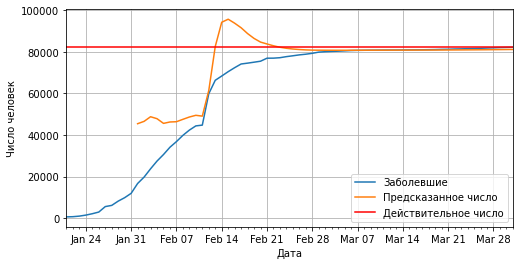

In [24]:
plot_convergence(data_model)

Порядок предсказанных цифр заражения на сегодня стал близким к действительному в середине февраля, то есть уже ближе к концу роста. Однако в китайских данных был один артефакт в середине, когда скорость резко изменилась, что повлияло на поведение функции.

В целом, однако, **предсказательная способность у модели слабая**.

# Пробуем делать прогноз

## Прогноз по лидирующим странам

И всё же попробуем сделать прогноз. У каждой страны есть свои особенности, поэтому модель нужно подбирать для каждого случая в отдельности. Сделаем это для лидирующих стран по числу заражённых.

In [25]:
top = 15
top_countries_predict = confirmed[get_top_countries_names(top)].copy()
top_countries_predict[top_countries_predict < 200] = np.nan
top_countries_predict = top_countries_predict.rolling(4).mean()

top_countries_predict = top_countries_predict.apply(
    lambda x: fit_model(x)).transpose()
top_countries_predict['mrt_date'] = (top_countries_predict['mrt_date']
                                     .dt.strftime('%Y-%m-%d'))

print('Прогноз на {:%Y-%m-%d}:'.format(today))
top_countries_predict

Прогноз на 2020-04-01:


,a,a_std,b,b_std,c,c_std,mrt,mrt_date,mrt_days,start_date,R0
Country/Region,,,,,,,,,,,
US,265888,8796,714.788,38.6894,0.298288,0.00500926,19827,2020-03-30,22,2020-03-08,3.4
Italy,127613,1543,135.734,4.35837,0.185741,0.00207671,5915,2020-03-24,26,2020-02-27,5.4
Spain,140756,4985,154.629,6.14306,0.227108,0.00438099,7987,2020-03-29,22,2020-03-07,4.4
China,81174,263,34.8377,2.55639,0.217937,0.00448569,4418,2020-02-10,16,2020-01-25,4.6
Germany,101177,5021,120.732,7.43047,0.223002,0.00670903,5623,2020-03-28,21,2020-03-07,4.5
France,85714,3747,113.766,3.12913,0.191007,0.00341048,4070,2020-03-30,24,2020-03-06,5.2
Iran,78793,15805,29.9718,4.12572,0.111372,0.00854357,2191,2020-03-31,30,2020-03-01,9
United Kingdom,58688,3963,182.845,6.79963,0.221451,0.00376358,3238,2020-04-02,23,2020-03-10,4.5
Switzerland,18368,277,63.5859,2.77055,0.259458,0.00450568,1191,2020-03-25,16,2020-03-09,3.9


Напоминаю, что `a` это максимальное число заражённых, `mrt_date` это дата (спустя `mrt_days` дней с начала моделирования `start_date`), когда скорость заражения будет максимальной и равна `mrt` заражённых в день.

Вообще говоря, некоторые решения могут получиться нестабильными, это видно по большому значению `a_std` или по завышенному значению `a`, как и других коэффициентов. Кроме того, решения **очень** чувствительны к ошибкам исходных данных. Это один из недостатков принятого подхода и модели.

Кроме того, если дата с максимальным ростом `mrt_date` очень близка к последней дате, на которую вообще имеются данные, то опять же вероятны неточности в решении.

Решения будут тем лучше, чем ближе рост к завершению, то есть при приближениии к верхней асимптоте. Понятно, что с точки зрения предсказания это слабое место. Более сложные и реалистичные модели позволяют моделировать процессы распространения эпидемий и на начальных этапах, принимая во внимание многие факторы. Логистическая функция такими свойствами не обладает ввиду своей простоты.

`R0` это заразность, то есть сколько один человек заразит других. Для топовых стран:

In [26]:
'Базовое репродуктивное число COVID-19 R0 = {:.1f}'.format(top_countries_predict.R0.median())

'Базовое репродуктивное число COVID-19 R0 = 4.5'

Для сравнения:
* R0 сезонного гриппа — 0.9 – 2.1;
* R0 гриппа «Испанки» — 1.4 – 2.8;
* R0 кори — 12-18 .

Наш коронавирус на данный момент весьма заразен, куда больше любого из гриппов.

Высокая заразность и высокая летальность довольно очевидно должны приводить к большому числу жертв в абсолютной мере.